### TODO
- Assign projects unique colors and use them everywhere
- DONE Setup Keyboard shortcut to view plots
- Set up minutely regeneration of plots
- Show date in bar plots
- Show goals from previous days

In [1]:
CLEAR_NAME_CACHE = False

In [2]:
import requests
import base64
import json
import os
import time
import datetime as dt
from datetime import datetime, date
import pytz
import diskcache
import urllib.parse
from matplotlib import pyplot as plt
plt.rcParams.update({'font.family': 'Noto Sans CJK JP'})
import numpy as np
from operator import itemgetter, attrgetter
import pandas as pd
from pdb import set_trace
from IPython.display import clear_output

# Functionality

## Utils

In [3]:
def now():
    return datetime.utcnow().replace(tzinfo=pytz.utc)

def filter_dict(d, keys):
    return list(map(lambda x: {k: v for k, v in x.items() if k in keys}, d))

## Setting up Toggl API
Note that a safe API request rate is 1 request per second.

In [4]:
project_dir = os.path.abspath('')

API_version = 'v9'
prefix = f"https://api.track.toggl.com/api/"

API = {
    "time_entries" :          prefix + "v8" + "/time_entries",
    "get_current_time_entry": prefix + API_version + "/me/time_entries/current", 
    "me_info" :               prefix + API_version + "/me",
    "projects_me" :           prefix + API_version + "/me/projects",
    "projects_ws" :           prefix + API_version + "/workspaces/4143224/projects",
    "workspaces" :            prefix + API_version + "/workspaces",
}

with open(f"{project_dir}/api_key.txt") as f:
    API_token = f"{f.read()}:api_token"
API_token_base64 = base64.b64encode(API_token.encode('ascii')).decode('ascii')

project_id_names = diskcache.Cache(f"{project_dir}/project_id_names.cache")
if CLEAR_NAME_CACHE:
    project_id_names.clear()

In [5]:
def fetch(url, headers={}):
    headers={"Content-Type": "application/json", 
                                    "Host": "api.track.toggl.com",
                                    "authorization": f"Basic {API_token_base64}", 
                                    **headers}
    r = requests.get(url, headers=headers)
    return json.loads(r.content.decode('utf-8'))

def fetch_project(project_id):
    return fetch(f"{API['projects_ws']}/{project_id}")

In [6]:
def update_current_time_entry_duration(time_entry):
    time_entry["duration"] = (datetime.utcnow().replace(tzinfo=pytz.utc) - \
                              time_entry["start"]).seconds
    return time_entry

def get_time_entries(start_date, end_date):
    date_to_str = lambda date: date.strftime('%Y-%m-%dT%H:%M:%S') + f'{date.strftime("%z")[:3]}:{date.strftime("%z")[3:]}'
    url_exts = '?'
    url_exts += f"start_date={urllib.parse.quote(date_to_str(start_date))}"
    url_exts += f"&end_date={urllib.parse.quote(date_to_str(end_date))}"
    time_entries = fetch(API['time_entries'] + url_exts)
        
    time_entries = [x for x in time_entries if 'pid' in x]
        
    for time_entry in time_entries:
        project_id = time_entry['pid']
        if project_id not in project_id_names:
            project_id_names[project_id] = fetch_project(project_id)
        time_entry['project_name'] = project_id_names[project_id]['name']
        
        time_entry['start'] = datetime.fromisoformat(time_entry['start'])
        if 'stop' in time_entry:
            time_entry['stop'] = datetime.fromisoformat(time_entry['stop'])
        if time_entry['duration'] < 0:
            time_entry = update_current_time_entry_duration(time_entry)        
    return time_entries

def get_day_entries(date):
    # TODO
    start_date = datetime.fromisoformat(f'{str(date)}T01:00:00+00:00')
    end_date = datetime.fromisoformat(f'{str(date)}T23:59:59+00:00')
    return get_time_entries(start_date, end_date)

def get_todays_entries():
    return get_day_entries(date.today())

def get_week_entries():
    pass

def get_month_entries():
    pass

def get_last_n_days(n):
    entries = []
    for i in range(n):
        entries.append(get_day_entries(date.today() - dt.timedelta(n-1-i)))
    return entries

def get_all_data():
    pass 

## Time entry processing

In [7]:
def accumulate(entries):
    times = {}
    for entry in entries:
        times[entry['project_name']] = times.get(entry['project_name'], 0) + entry['duration']
    return sorted(list(times.items()), key=itemgetter(1))

def n_acc(n, sleep=False):
    entries = get_last_n_days(n)
    entries = list(map(accumulate, entries))
    if not sleep:
        entries = [[(k,v) for k,v in x if k != 'sleep睡眠'] for x in entries]
    return entries

## Plotting Logic

In [8]:
def general_axis(ax):
    ax.set_facecolor('white')
    return ax

def pie(ax, data):
    name, size = [x[0] for x in data], [x[1] for x in data]
    ax.pie(size, labels=name, autopct='%1.1f%%',
            shadow=True, startangle=180-45, explode=0.05 * np.random.rand(len(data)))
    return ax

def bar(ax, data):
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    for j, d in enumerate(data): 
        height = 0
        cmap = plt.cm.get_cmap('hsv', len(d))
        inverse_shrink = 5
        for i, (x,y) in enumerate(reversed(d)):
            y_scaled = y/(60*60)
            new_height = height + y_scaled
            ax.bar(j, height=y_scaled, tick_label='Today', alpha=1, color=cmap(i), bottom=height, edgecolor='black')
            ax.text(j, new_height, str(dt.timedelta(seconds=y)) + ' ' + x, va='top', ha='center', size=8)
            height = new_height
    return ax

# Goals
def goal_plot(axs, daily_goals, acc):
    text_size = 14
    y_pos = np.arange(len(daily_goals))
    d_acc = dict(acc)
    percents = [d_acc.get(name, 0) / seconds * 100 for _,name,seconds in daily_goals]
    general_axis(axs)
    axs.grid(axis='x')
    axs.barh(y_pos, percents)
    axs.tick_params(axis='x', labelsize=text_size)
    axs.set_yticks(y_pos, labels=[name for _,name,_ in daily_goals], size=text_size)
    axs.axvline(100, color='red')
    axs.set_xlim(0, 115)
    for y, (_,name,target) in zip(y_pos, daily_goals):
        axs.text(3, y, f"{dt.timedelta(seconds=d_acc.get(name, 0))} / {dt.timedelta(seconds=target)}", size=text_size)
    return axs

# Goals

In [9]:
print("Projects:")
for k in project_id_names:
    print(k, project_id_names[k]['name'])
print()

185499583 morning
163125874 improvements
165777572 social productive社会的、生産的
186239363 evening
163125866 sleep睡眠
187567761 unknown
165947128 entertainment
165352471 communicationコミュニケーション
165598846 cook食べ物
165297879 maintenanceメンテナンス
187511108 nonfiction, listen
163125865 meditate瞑想
184591500 commute
185247273 write
165296570 toiletトイレ
165304788 sportトレニング
163126231 eat食べる
165296445 social社会的
186567117 life_debugging
165297234 plan計画
163125846 tulpa_training
165301785 AIA_original
187084115 aia_discussion
186119188 reflect
165296497 research研究
185725569 frisky
186454695 SERI_MATS_event
185927511 AIA_skillup


In [10]:
print("Daily goals, given as project_id and minutes:")
daily_goals = [
               (163125865, 40), # Meditate           
               (165304788, 30), # Sport
               (163125846,  5), # Tulpa training
               (165301785, 60), # AIA original
               (186119188,  5), # Reflect               
             ]
daily_goals = [(pid, project_id_names[pid]['name'], mins*60) for pid, mins in daily_goals]
for i in daily_goals:
    print(i)
print()

(163125865, 'meditate瞑想', 2400)
(165304788, 'sportトレニング', 1800)
(163125846, 'tulpa_training', 300)
(165301785, 'AIA_original', 3600)
(186119188, 'reflect', 300)


# Visualisations

In [11]:
def generate_goal_plot(show_plot=True):
    scale = 1.5
    text_size = 14
    fig, axs = plt.subplots(3, 2, figsize=(17*scale, 9*scale))
    figtitle = "1_goals"
    fig.suptitle(figtitle, fontsize=text_size*3)
    axs = axs.flatten()
    titles = [str(date.today()), ]
    for i, a in enumerate(reversed(acc_7[1:])):
        goal_plot(axs[i], daily_goals, a)
        axs[i].set_title(str(str(date.today() - dt.timedelta(i))))
    plt.savefig(f"plots/{figtitle}.png", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

In [12]:
def generate_pies(show_plot=True):
    text_size = 14
    fig, axs = plt.subplots(1,1,figsize=(20,20))
    figtitle = "3_pie_1"
    fig.suptitle(figtitle, fontsize=text_size*3)
    pie(axs, acc_7[-1])
    plt.savefig(f"plots/{figtitle}.png", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

    fig, axs = plt.subplots(1,1,figsize=(20,20))
    figtitle = "3_pie_2_no-sleep"
    fig.suptitle(figtitle, fontsize=text_size*3)
    pie(axs, acc_7_nosleep[-1])
    plt.savefig(f"plots/{figtitle}.png", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

In [16]:
def generate_bars(show_plot=True):
    text_size = 14
    scale = 1.5*1.41
    fig, axs = plt.subplots(1,1,figsize=(16*scale,9*scale))
    figtitle = "2_bar_1"
    fig.suptitle(figtitle, fontsize=text_size*3)
    bar(axs, acc_7)
    axs.axhline(24, color='red')
    plt.savefig(f"plots/{figtitle}.png", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

    fig, axs = plt.subplots(1,1,figsize=(16*scale,9*scale))
    figtitle = "2_bar_2_no-sleep"
    fig.suptitle(figtitle, fontsize=text_size*3)
    bar(axs, acc_7_nosleep)
    plt.savefig(f"plots/{figtitle}.png", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

generated 2022-11-30 15:21:17.308388

KeyboardInterrupt: 

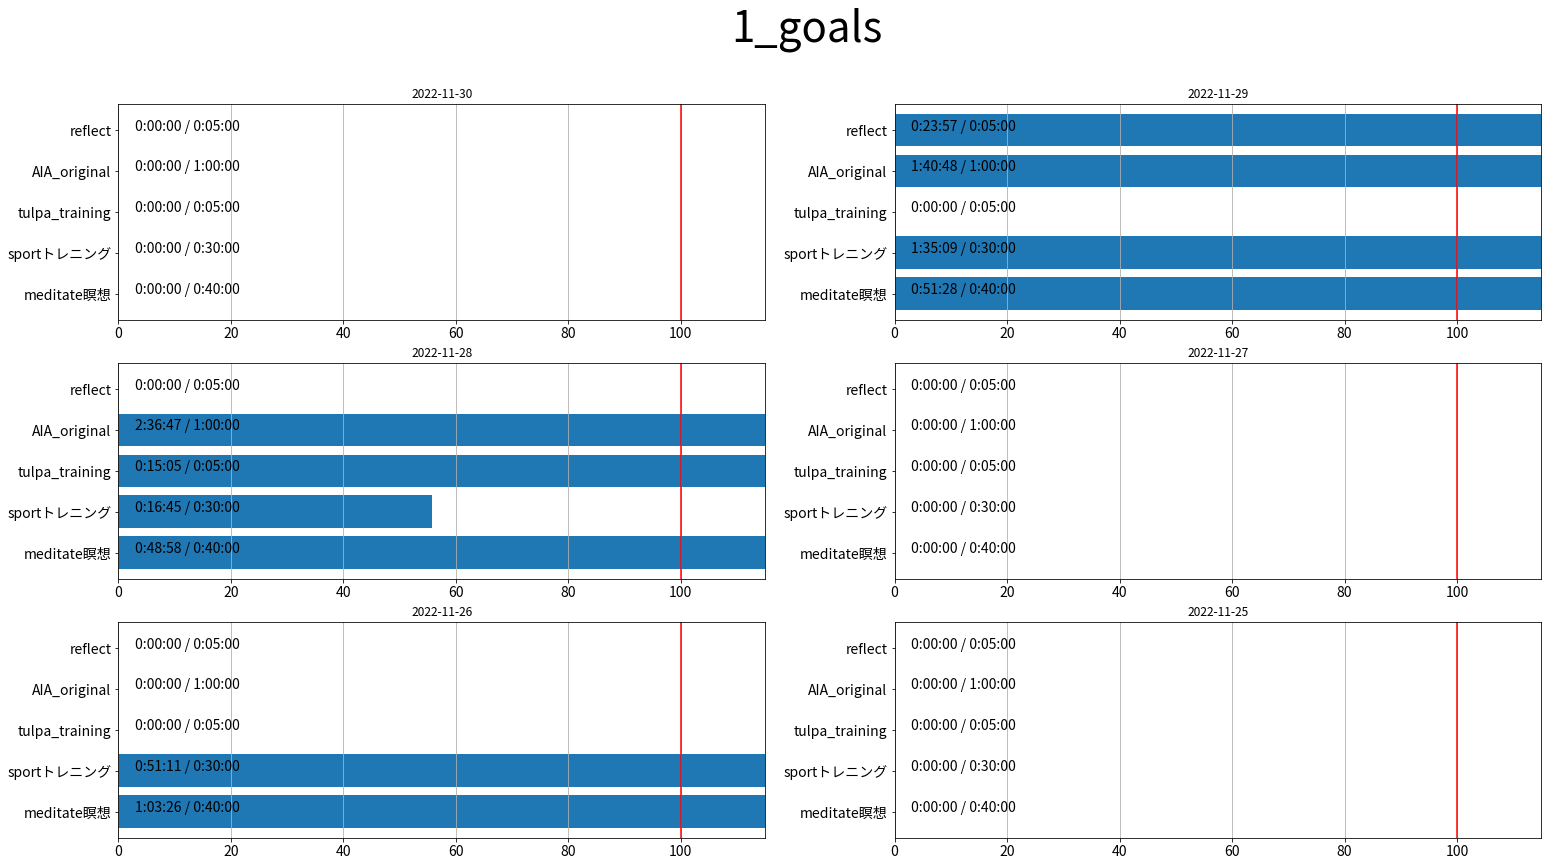

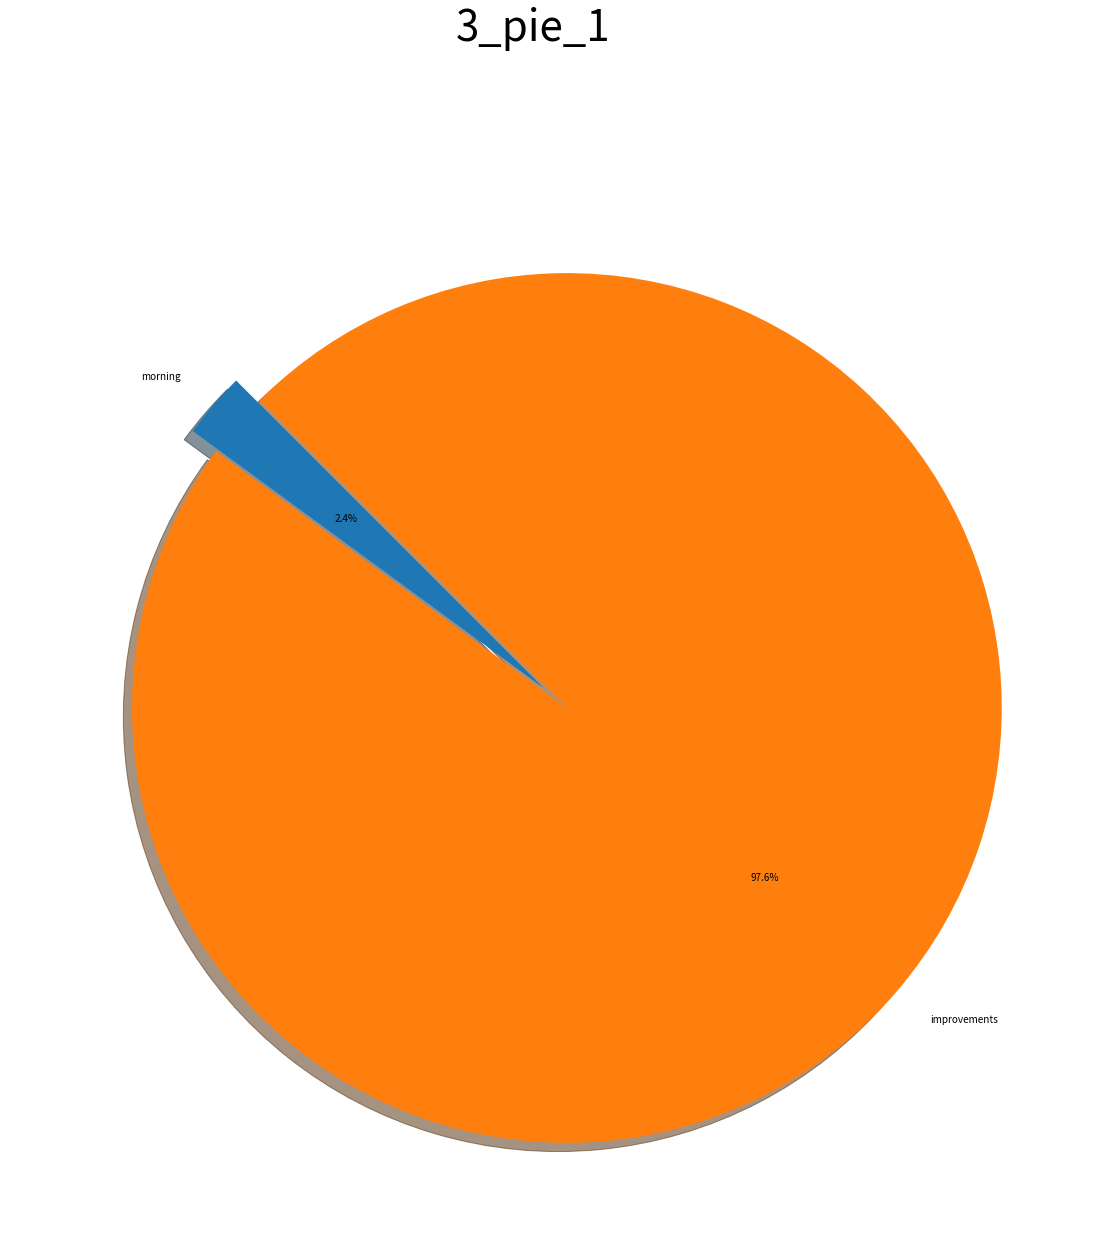

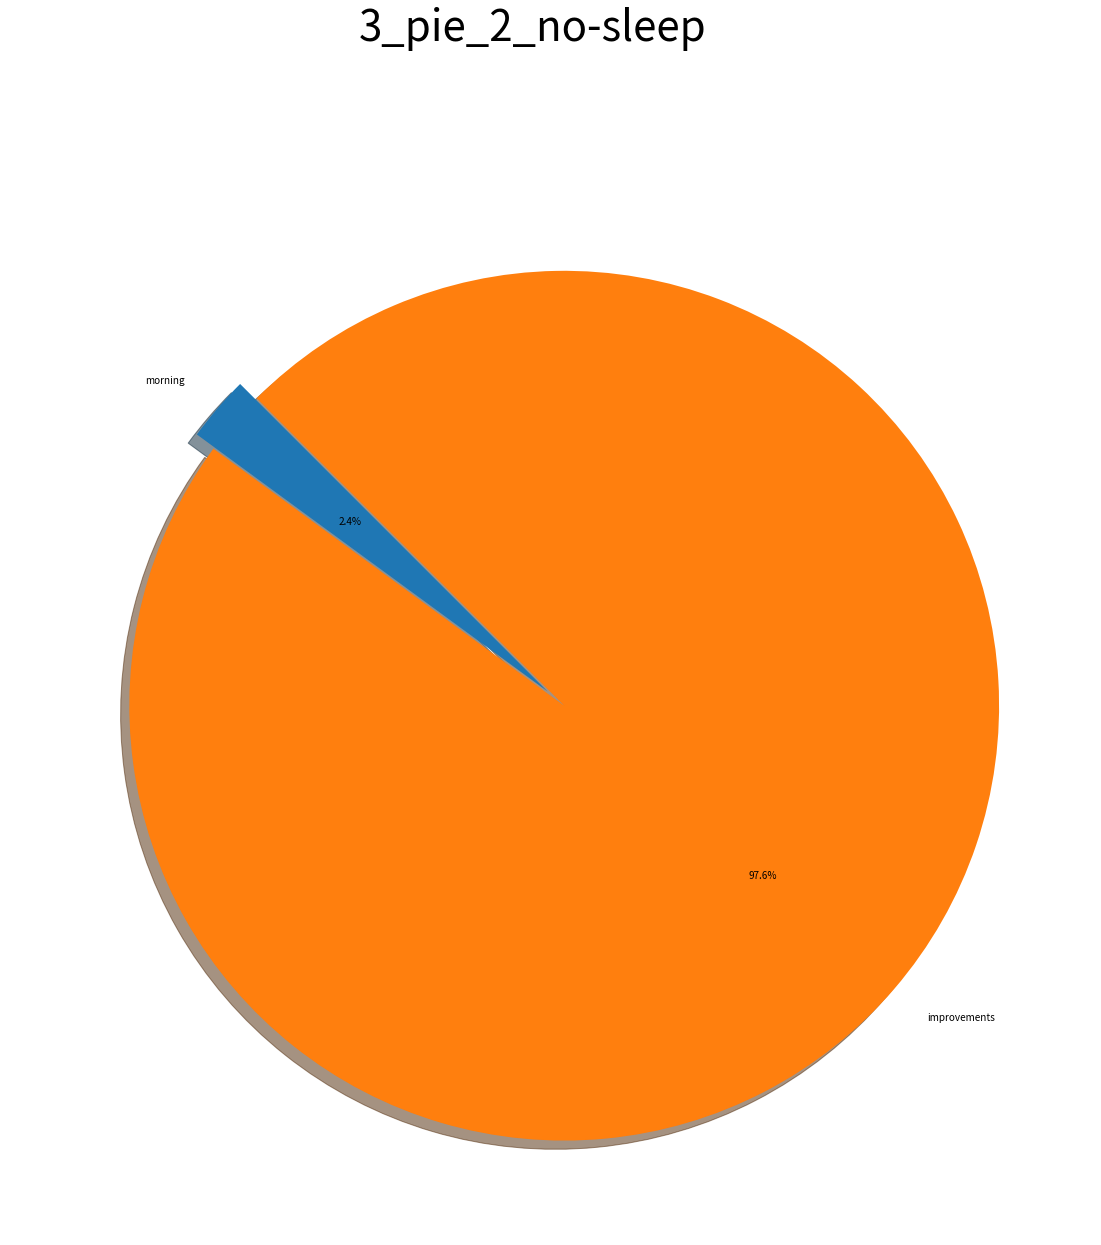

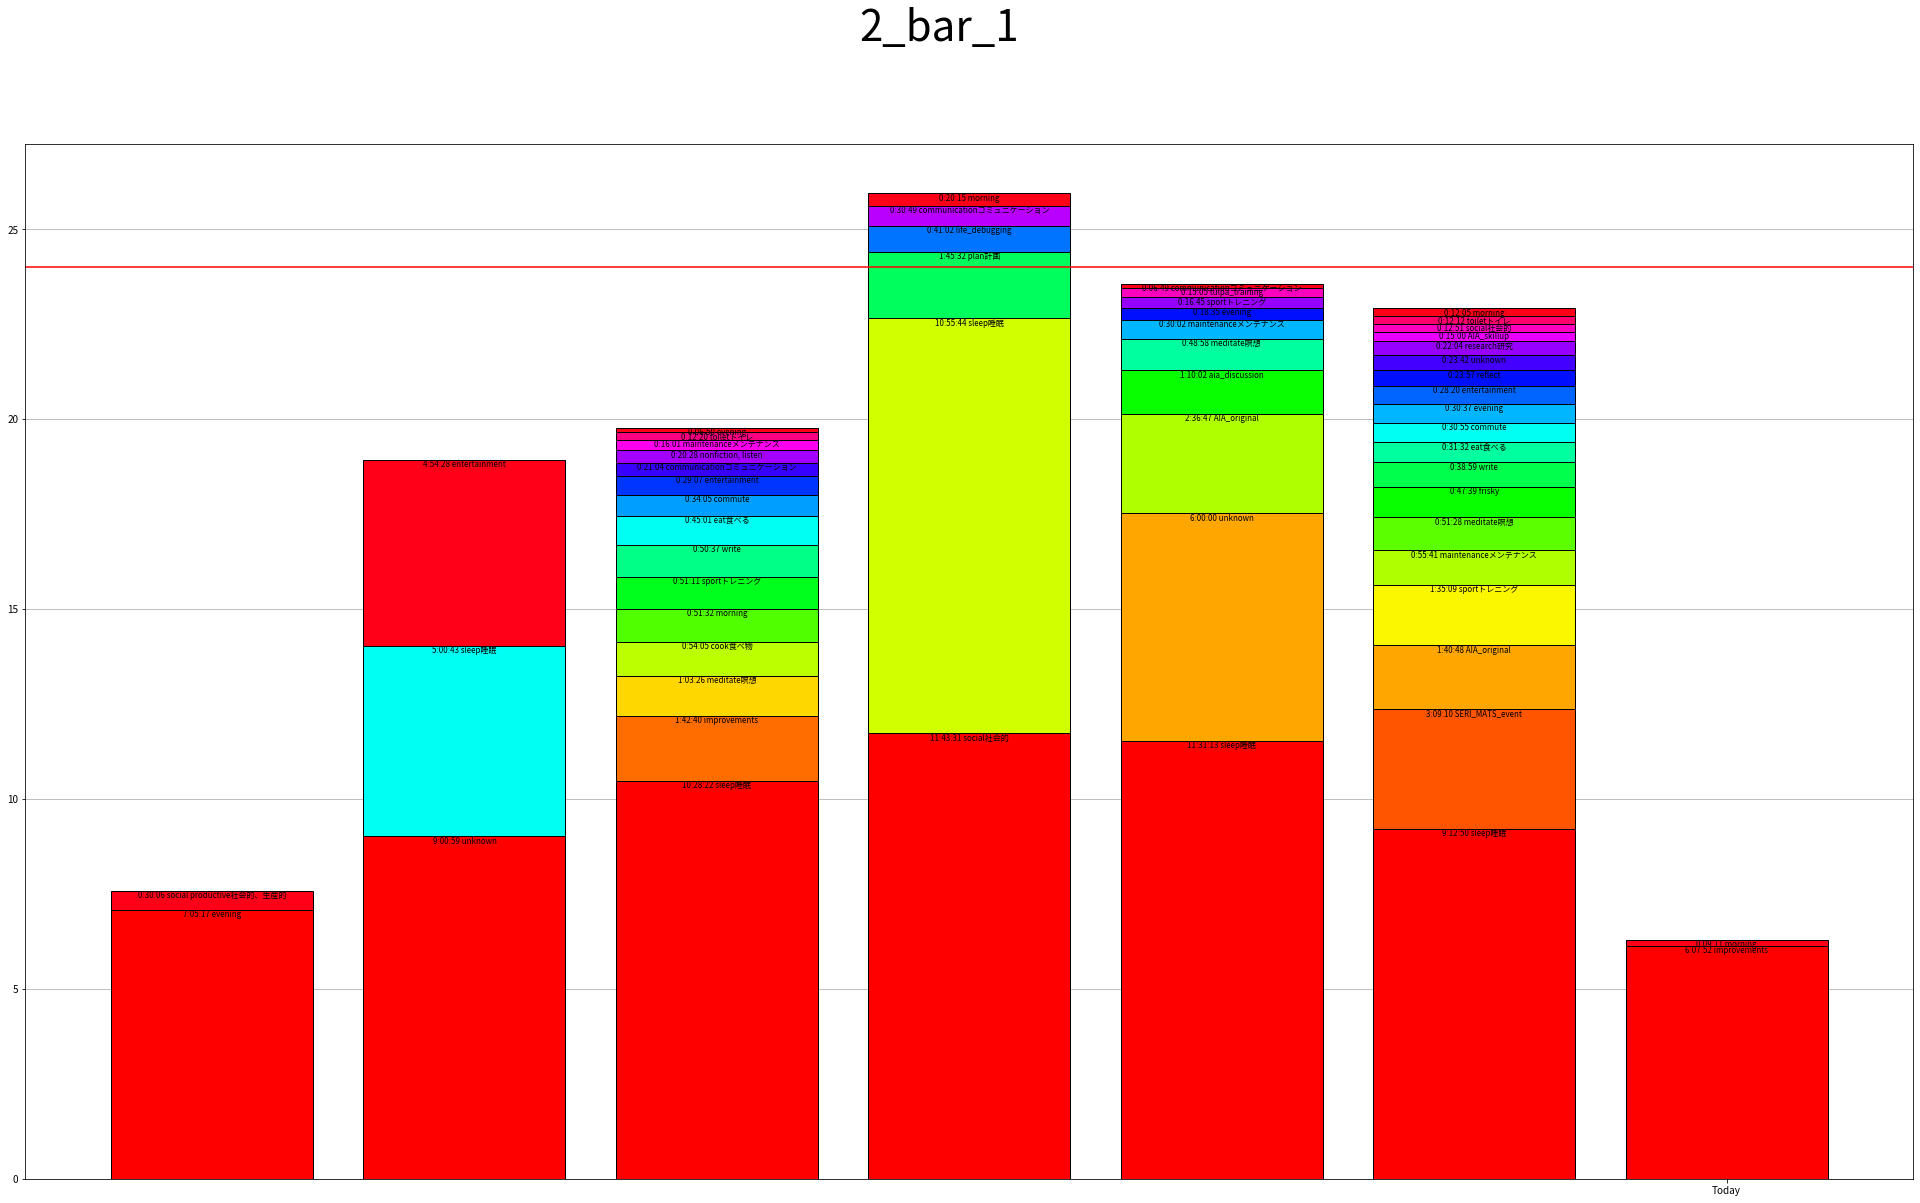

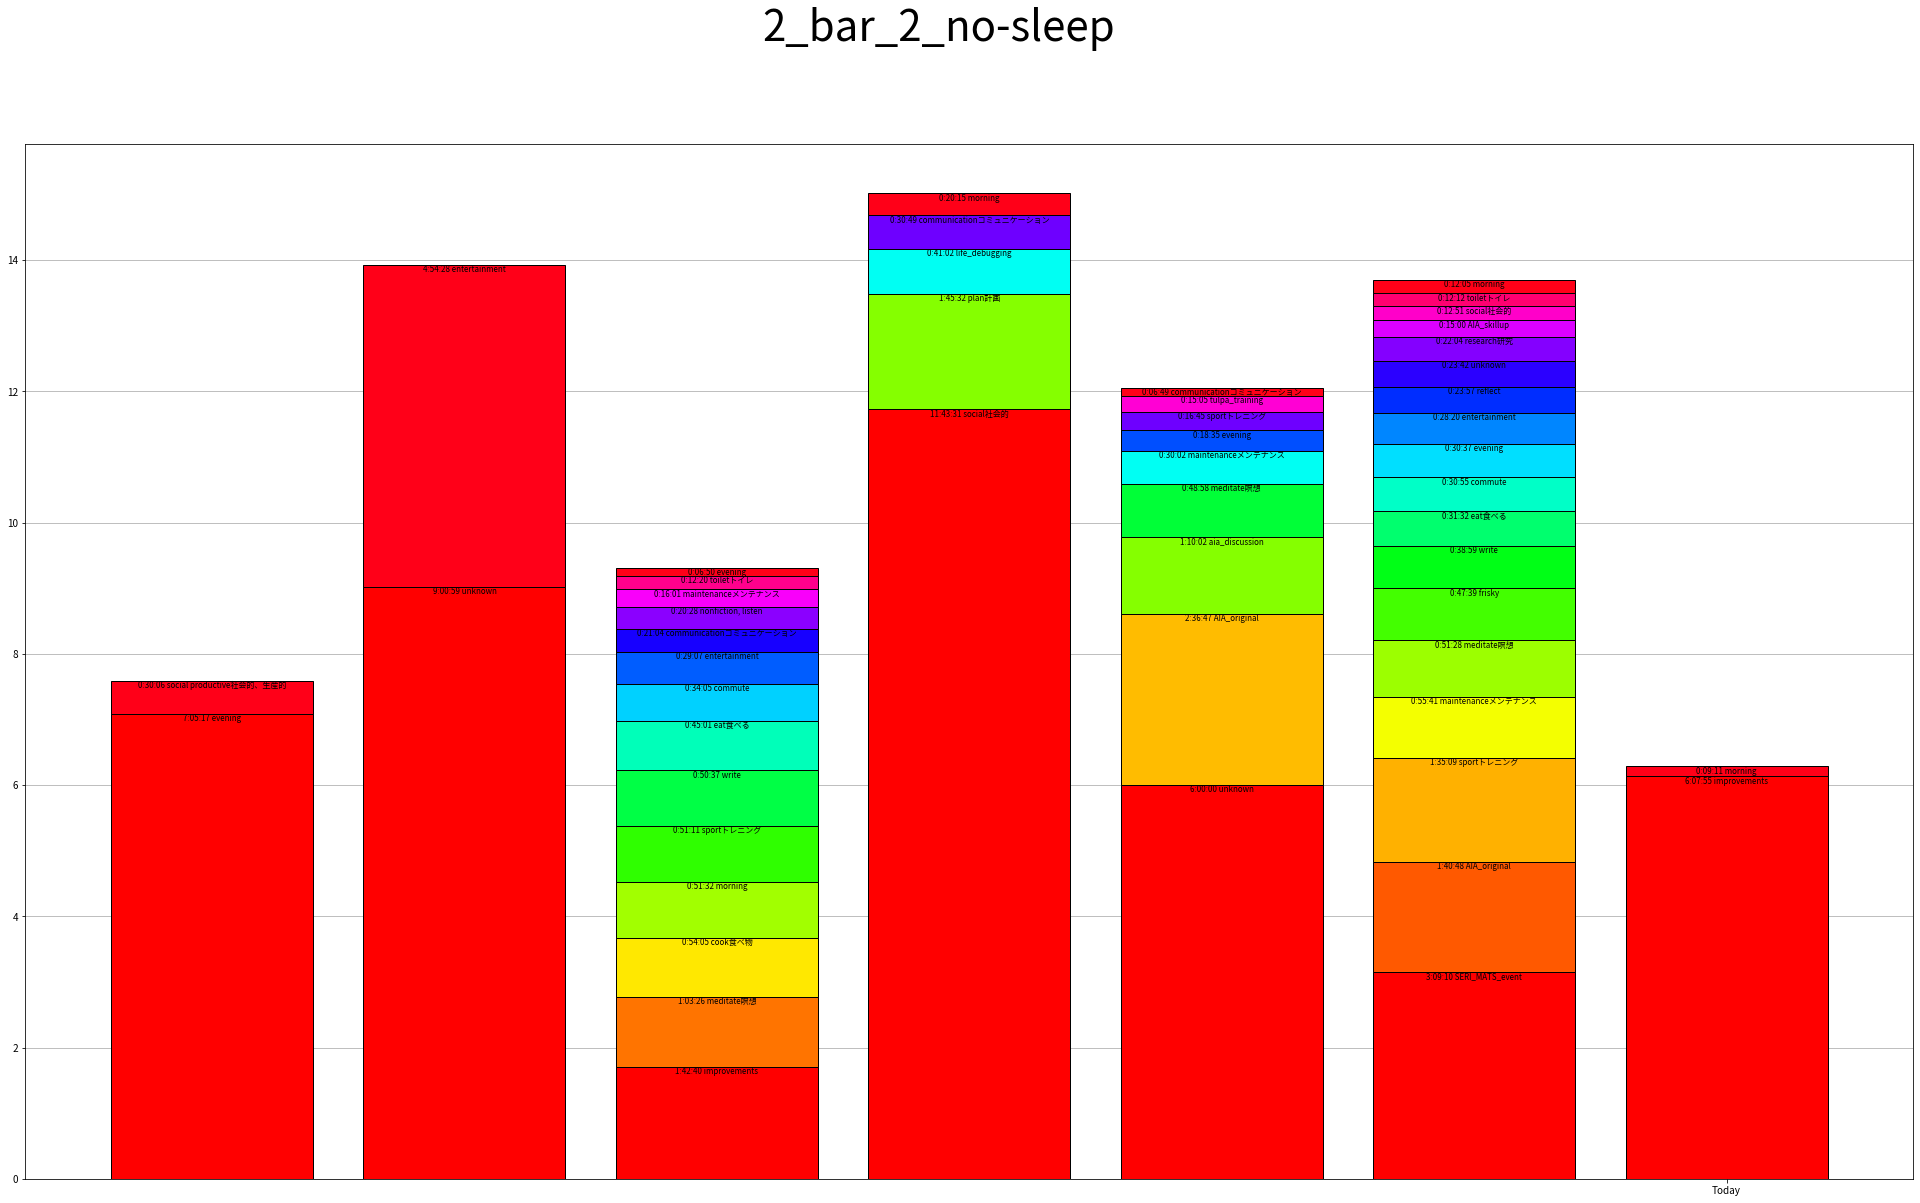

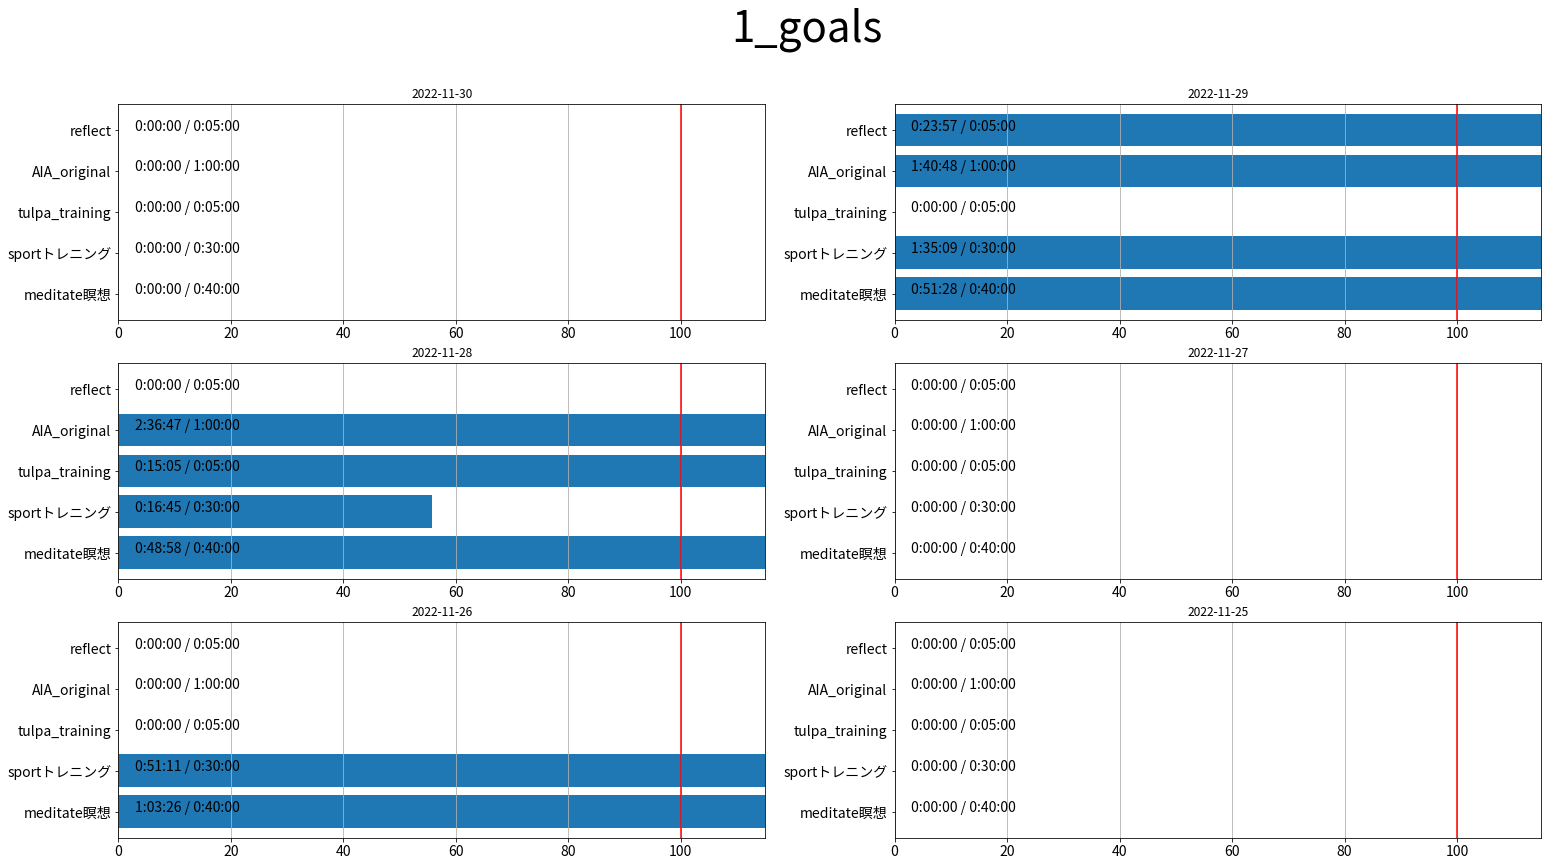

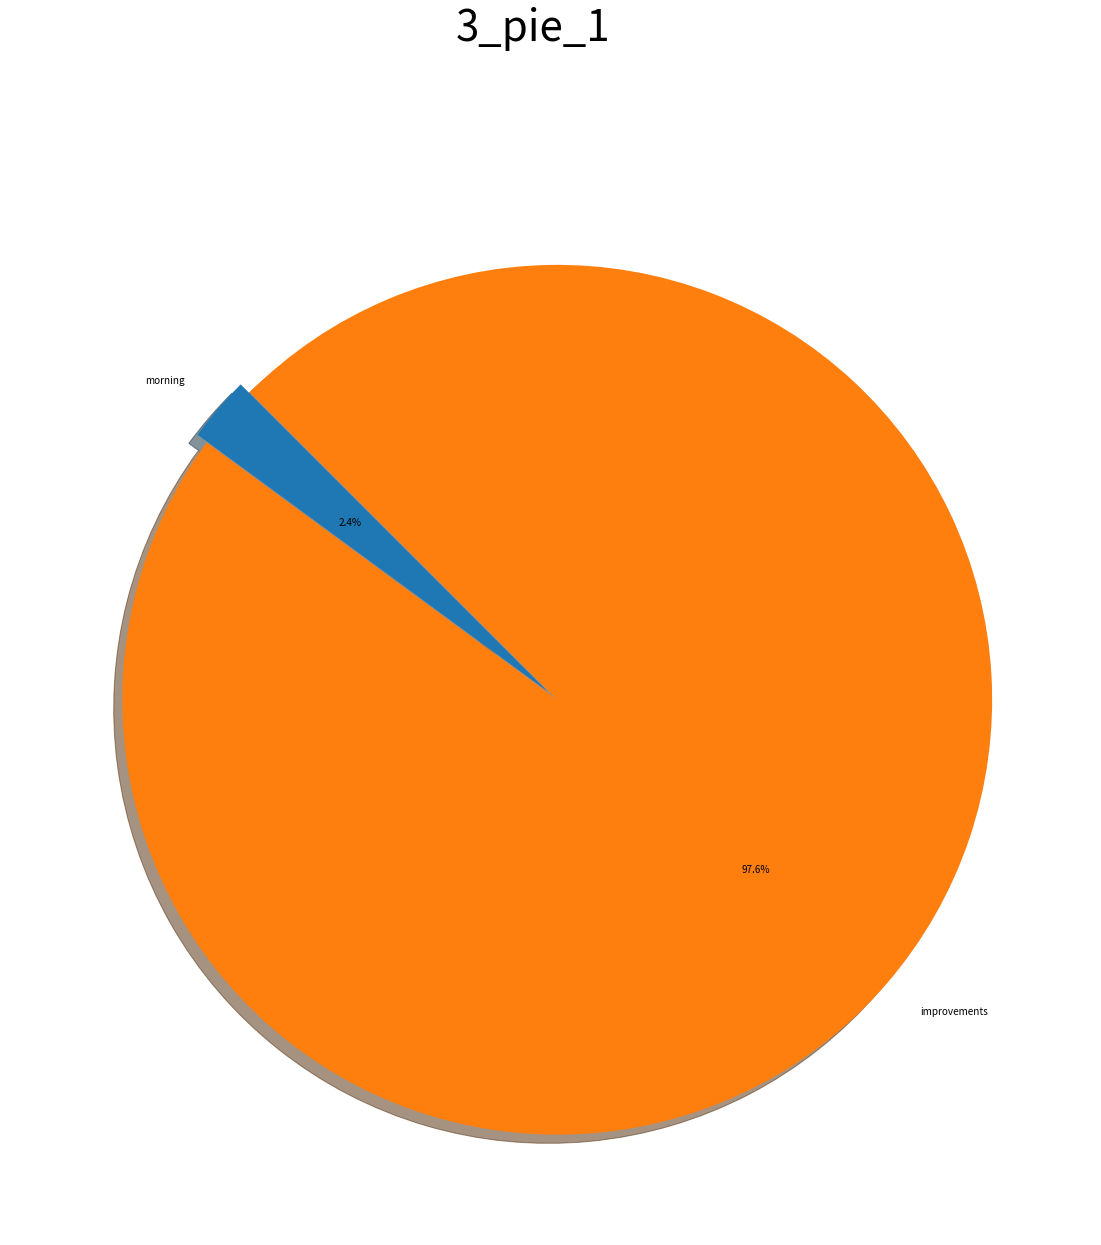

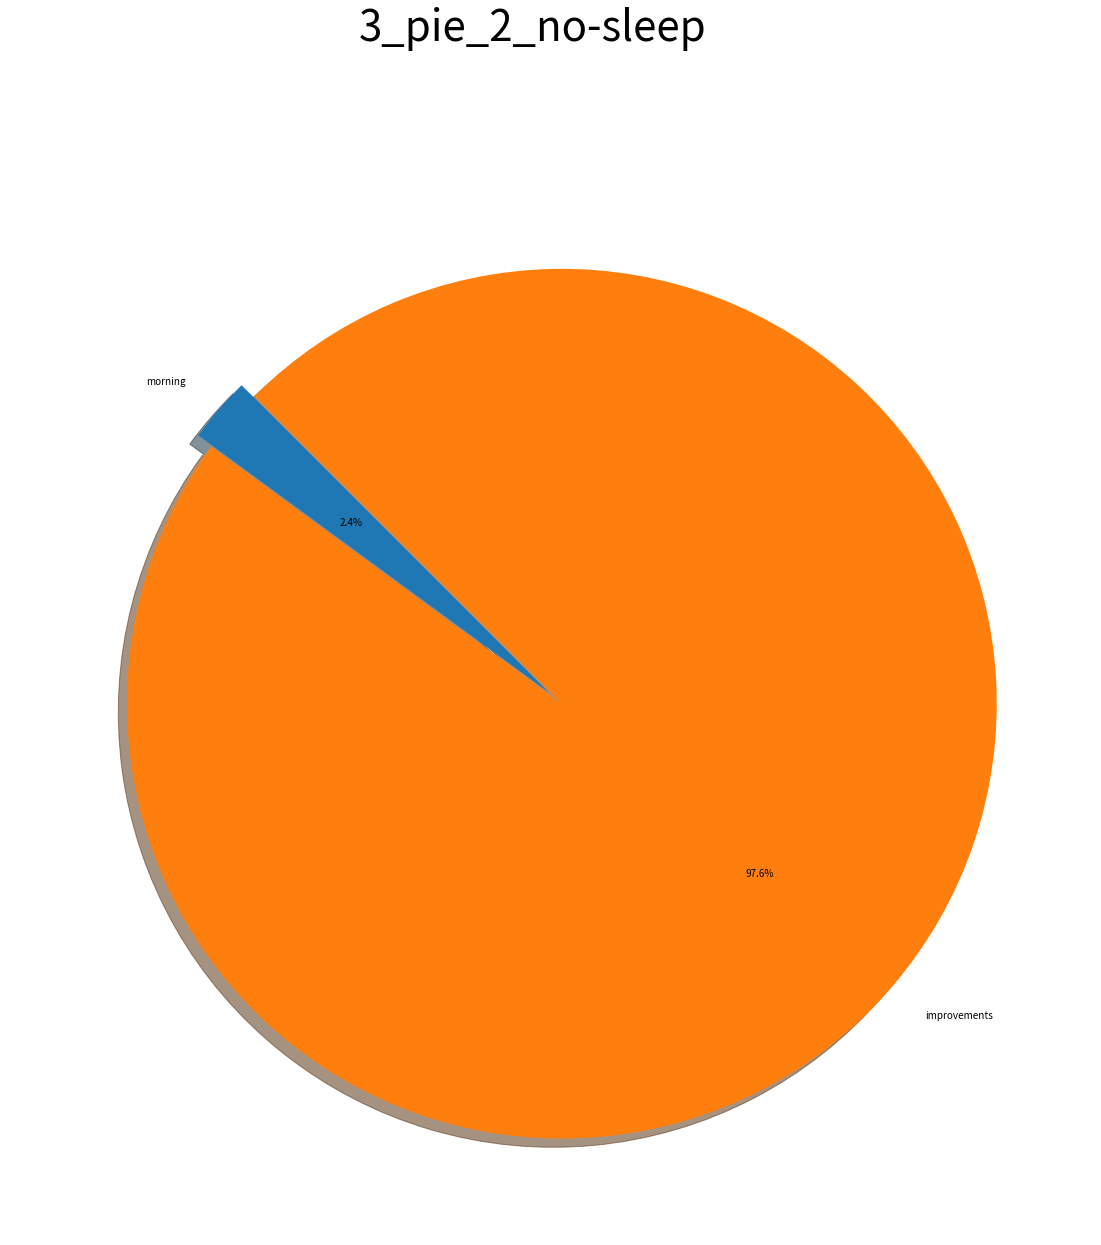

Error in callback <function flush_figures at 0x7fca6f24d900> (for post_execute):


KeyboardInterrupt: 

In [17]:
# Continuously fetch the data and update the plots
WAIT = 90
SHOW_PLOTS = False
while True:
    while True:
        try:
            acc_7 = n_acc(7, True)
            acc_7_nosleep = n_acc(7)
            break
        except:
            print(f"Connection error. Sleeping {WAIT}s")
            time.sleep(WAIT)
    clear_output()
    generate_goal_plot(show_plot=SHOW_PLOTS)
    generate_pies(show_plot=SHOW_PLOTS)
    generate_bars(show_plot=SHOW_PLOTS)
    print(f"\r last generation: {datetime.now()}",end="")
    time.sleep(WAIT)